<a href="https://colab.research.google.com/github/Malavika-Gupta/Vehicle-Number-Plate-Detection/blob/main/Vehicle_number_plate_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install torch torchvision
!pip install pillow opencv-python


In [3]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d aslanahmedov/number-plate-detection -p /content


Dataset URL: https://www.kaggle.com/datasets/aslanahmedov/number-plate-detection
License(s): copyright-authors
 99% 409M/413M [00:20<00:00, 20.5MB/s]
100% 413M/413M [00:20<00:00, 21.3MB/s]


In [6]:
!unzip /content/number-plate-detection.zip -d /content/dataset
!ls /content/dataset


Archive:  /content/number-plate-detection.zip
  inflating: /content/dataset/TEST/TEST.jpeg  
  inflating: /content/dataset/TEST/TEST.mp4  
  inflating: /content/dataset/data.yaml  
  inflating: /content/dataset/images/N1.jpeg  
  inflating: /content/dataset/images/N1.xml  
  inflating: /content/dataset/images/N100.jpeg  
  inflating: /content/dataset/images/N100.xml  
  inflating: /content/dataset/images/N101.jpeg  
  inflating: /content/dataset/images/N101.xml  
  inflating: /content/dataset/images/N102.jpeg  
  inflating: /content/dataset/images/N102.xml  
  inflating: /content/dataset/images/N103.jpeg  
  inflating: /content/dataset/images/N103.xml  
  inflating: /content/dataset/images/N104.jpeg  
  inflating: /content/dataset/images/N104.xml  
  inflating: /content/dataset/images/N105.jpeg  
  inflating: /content/dataset/images/N105.xml  
  inflating: /content/dataset/images/N106.jpeg  
  inflating: /content/dataset/images/N106.xml  
  inflating: /content/dataset/images/N107.jpeg 

In [7]:
import yaml

with open('/content/dataset/data.yaml') as f:
    data_info = yaml.safe_load(f)
print(data_info)


{'train': 'data_images/train', 'val': 'data_images/test', 'nc': 1, 'names': ['license_plate']}


In [8]:
!ls /content/dataset


data.yaml  images  TEST


In [9]:
import os
import xml.etree.ElementTree as ET

# Directory containing the XML annotations
annotation_dir = "/content/dataset/images"

# Function to parse a single XML file
def parse_xml(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    # Image details
    image_info = {
        "filename": root.find("filename").text,
        "width": int(root.find("size/width").text),
        "height": int(root.find("size/height").text),
        "objects": []
    }

    # Bounding box details for each object
    for obj in root.findall("object"):
        obj_name = obj.find("name").text
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        # Append object information
        image_info["objects"].append({
            "name": obj_name,
            "bbox": [xmin, ymin, xmax, ymax]
        })

    return image_info

# Parse all XML files in the directory
annotations = []
for filename in os.listdir(annotation_dir):
    if filename.endswith(".xml"):
        annotation_path = os.path.join(annotation_dir, filename)
        image_info = parse_xml(annotation_path)
        annotations.append(image_info)

# Display the parsed annotations
for annotation in annotations[:5]:  # Display first 5 annotations
    print(annotation)


{'filename': 'N232.jpeg', 'width': 740, 'height': 490, 'objects': [{'name': 'number_plate', 'bbox': [286, 216, 451, 258]}]}
{'filename': 'N192.jpeg', 'width': 1250, 'height': 703, 'objects': [{'name': 'number_plate', 'bbox': [543, 390, 769, 461]}]}
{'filename': 'N121.jpeg', 'width': 802, 'height': 557, 'objects': [{'name': 'number_plate', 'bbox': [311, 324, 506, 370]}]}
{'filename': 'N213.jpeg', 'width': 350, 'height': 196, 'objects': [{'name': 'number_plate', 'bbox': [131, 129, 209, 153]}]}
{'filename': 'N160.jpeg', 'width': 400, 'height': 300, 'objects': [{'name': 'number_plate', 'bbox': [153, 196, 251, 217]}]}


In [10]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class LicensePlateDataset(Dataset):
    def __init__(self, annotations, img_folder, transform=None):
        self.annotations = annotations
        self.img_folder = img_folder
        self.transform = transform if transform is not None else transforms.ToTensor()

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        img_path = os.path.join(self.img_folder, ann['filename'])  # Updated from 'image' to 'filename'
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)  # Apply the transformation

        # Assuming each annotation has only one object for simplicity
        boxes = torch.tensor(ann['objects'][0]['bbox'], dtype=torch.float32)  # Adjust to your data structure

        target = {
            "boxes": boxes.unsqueeze(0),  # Ensure 'boxes' is of shape [N, 4]
            "labels": torch.tensor([1], dtype=torch.int64),  # Assuming single label for number plates
        }

        return img, target

    def __len__(self):
        return len(self.annotations)

# Example usage
dataset = LicensePlateDataset(annotations, '/content/dataset/images')


In [11]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [12]:
import torchvision
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # Background + number plate
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 174MB/s]


In [13]:
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {losses.item():.4f}")


Epoch 1, Loss: 0.1501
Epoch 2, Loss: 0.1396
Epoch 3, Loss: 0.2125
Epoch 4, Loss: 0.1210
Epoch 5, Loss: 0.1065
Epoch 6, Loss: 0.0835
Epoch 7, Loss: 0.0812
Epoch 8, Loss: 0.1190
Epoch 9, Loss: 0.0889
Epoch 10, Loss: 0.0992


In [17]:
test_dir = '/content/dataset/TEST/'
print("Available images:")
print(os.listdir(test_dir))

Available images:
['TEST.jpeg', 'TEST.mp4']


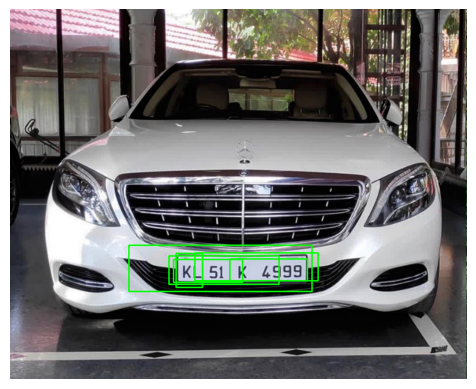

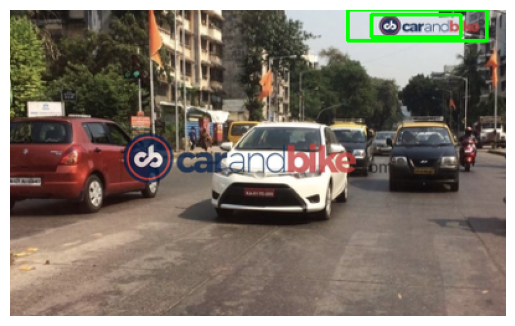

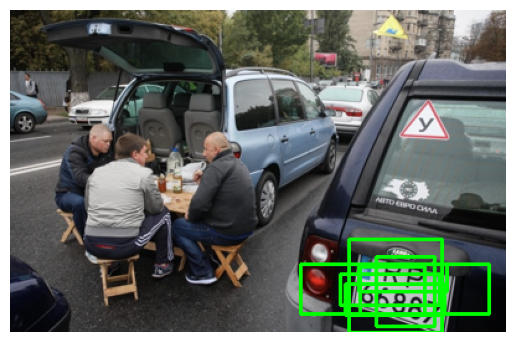

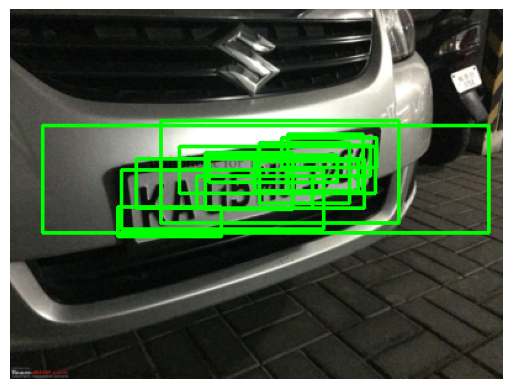

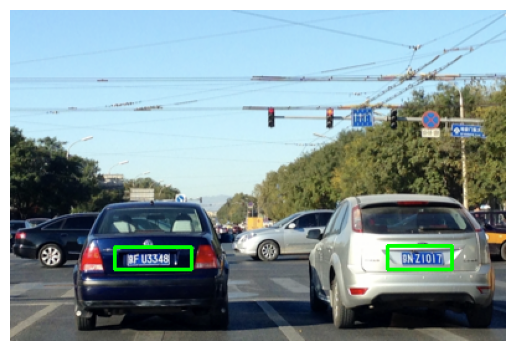

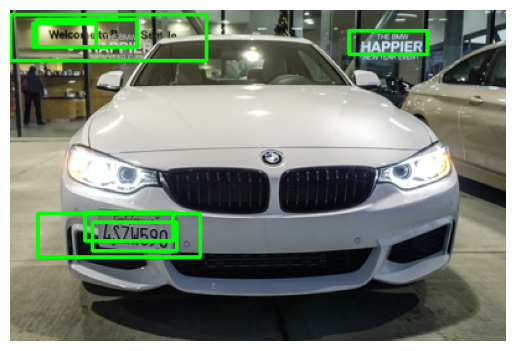

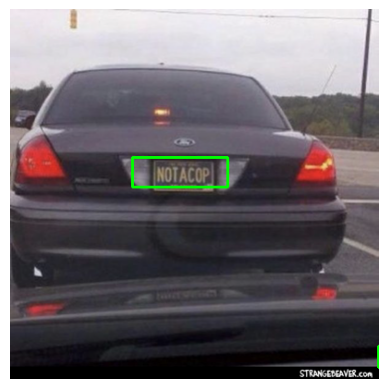

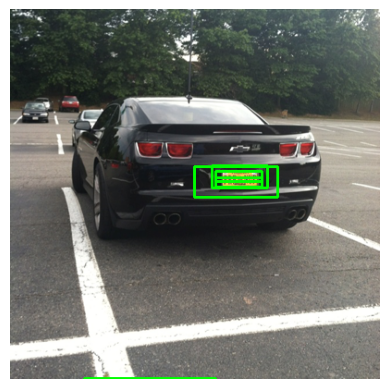

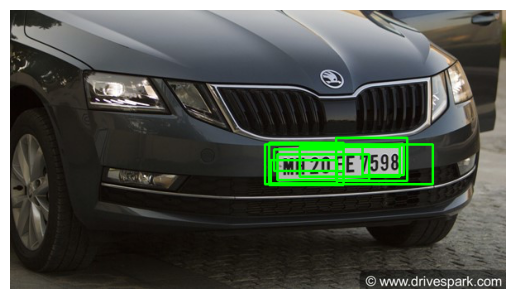

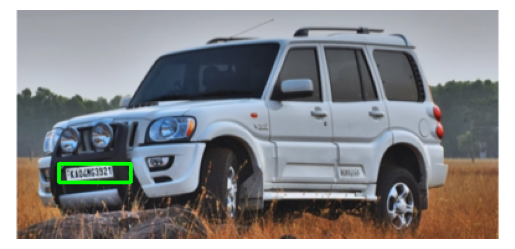

In [19]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, images):
    model.eval()
    with torch.no_grad():
        for img_path in images:
            img = Image.open(img_path).convert("RGB")
            img_tensor = torchvision.transforms.functional.to_tensor(img).to(device)
            predictions = model([img_tensor])[0]

            img_np = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

            if 'boxes' in predictions:
                for box in predictions['boxes']:
                    xmin, ymin, xmax, ymax = box.int().cpu().numpy()
                    cv2.rectangle(img_np, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

            plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

# Make sure the paths are correct
test_images = [
    '/content/dataset/TEST/TEST.jpeg',
    '/content/Cars1.png',
    '/content/Cars2.png',
    '/content/Cars3.png',
    '/content/Cars4.png',
    '/content/Cars5.png',
    '/content/Cars6.png',
    '/content/Cars7.png',
    '/content/Cars8.png',
    '/content/Cars9.png'
]
visualize_predictions(model, test_images)
